In [2]:
import os
import pickle
import numpy as np
from scipy.special import kl_div
from scipy.stats import pearsonr
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
#import config InlineBackend.figure_format = 'svg'
# import tensorflow as tf
# # silencing tensorflow warnings
# import logging
# logging.getLogger('tensorflow').setLevel(logging.FATAL)
from datetime import datetime
# tf.__version__ # printint out tensorflow version used
import stable_baselines3
import sb3_contrib
from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.results_plotter import load_results, ts2xy
from stable_baselines3.common.results_plotter import load_results, ts2xy
import optuna
# from stable_baselines3.bench import Monitor
from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3.common import results_plotter
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv
#stable_baselines.__version__ # printing out stable_baselines version used
import gym
import pickle
import cProfile 
import pandas as pd
import ast
import seaborn as sns
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 11}
matplotlib.rc('font', **font)

In [94]:
current_directory = os.getcwd()

# exp_id = "2022-03-18v45nsfU100GboR2"  
# exp_id = "2022-03-18v45nsfU100GboR3"
# exp_id = "2022-03-22v45nsfUp50100G7500R3"
exp_id = "2022-03-10v45nsfU100GR2" # best uniform
# exp_id = "2022-03-15v45nsfUp5100GR3" # best non-uniform
eval_name = "_no_tfb_more_snaps"
route_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"
eval_dir = route_dir+exp_id+"/_core_0/eval_results"+eval_name

# JOCN results 
# uniform no tfb
# eval_dir_h = route_dir+"2022-02-24nsfnotfbuniheuristics_eval/eval_results_no_tfb"  # 100G, k=5, 10k requests
# eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_eval/eval_results_no_tfb" # with service distribution
eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_eval/eval_results_no_tfb_more_snaps" # with service distribution

# eval_dir_h = route_dir+"2022-03-23nsfU100Gbo10chheuristics_eval/eval_results_no_tfb" # with 12.5%, 25%, 37.5%, 50%, 62.5%, 75%, 87.5%, 100% service distribution

# binary occupancy results, uniform no tfb
# eval_dir_h = route_dir+"2022-03-18nsfU100Gbofxdheuristics_eval/eval_results_no_tfb"  # binary occupancy
# eval_dir_h = route_dir+"2022-03-18nsfU100Gbofxdheuristics_eval/eval_results_no_tfb"  # binary occupancy

# uniform tfb
# eval_dir_h = route_dir+"2022-03-11nsfU100Gheuristics_eval/eval_results_tfb" # with service distribution

# non-uniform no tfb
# eval_dir_h = route_dir+"2022-03-04nsfUp50100G10kRheuristics_eval/eval_results_no_tfb" # 100G, k=5, 10k requests
# eval_dir_h = route_dir+"2022-03-11nsfU50100Gheuristics_eval/eval_results_no_tfb" # with service distribution
# non-uniform tfb
# eval_dir_h = route_dir+"2022-03-11nsfU50100Gheuristics_eval/eval_results_tfb" # with service distribution

# eval_dir_h = route_dir+"2022-02-24nsfunik3heuristics_eval/eval_results_no_tfb"
# eval_dir_h = route_dir+"2022-03-01nsfuni200Gk3heuristics_eval/eval_results_no_tfb"
# eval_dir_h = route_dir+"2022-03-03nsfuni500G2kRk5heuristics_eval/eval_results_no_tfb" # 500G, k=5, 2k requests 

# UNIFORM 50% perturbation NSFNET
# eval_dir_h = route_dir+"2022-03-04nsfUp50500G2kRheuristics_eval/eval_results_no_tfb" 

# "GRAVITY" NSFNET 
# eval_dir_h = route_dir+"2022-02-23v42nsftfb"+"/_core_0/eval_results"+"_tfb"
# eval_dir_h = route_dir+"2022-02-23v42nsftfbR3"+"/_core_0/eval_results"+"_no_tfb"
# eval_dir_h = route_dir+"2022-02-24nsfgravityk3heuristics_eval/eval_results_no_tfb"

# UNIFORM DTAG
# eval_dir_h = route_dir+"2022-02-24dtagnotfbuniheuristics_eval/eval_results_no_tfb" # 100G, k=5, 10k requests
# eval_dir_h = route_dir+"2022-02-24dtagunik3heuristics_eval/eval_results_no_tfb"  # 100G, k=3, 10k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200Gheuristics_eval/eval_results_no_tfb"  # 200G, k=5, 5k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200Gk3heuristics_eval/eval_results_no_tfb" # 200G, k=3, 5k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200G75kRk3heuristics_eval/eval_results_no_tfb" # 200G, k=5, 7.5k requests
# UNIFORM 50% perturbation DTAG
# eval_dir_h = route_dir+"2022-03-04dtagUp50500G2kRheuristics_eval/eval_results_no_tfb" # 500G, k=5, 2k requests 

In [95]:
def get_info(eval_dir, model, get_dist):
    df = pd.read_csv(eval_dir+"/evaluation_"+model+".monitor.csv", skiprows=1)
    eval_eps = df.index.values
    rewards = df['r'].to_numpy()
    sim_time = df['t'].to_numpy()
    services_accepted_ep = df['episode_services_accepted'].to_numpy()
    services_processed_ep = df['episode_services_processed'].to_numpy()
    services_accepted = df['services_accepted'].to_numpy()
    services_processed = df['services_processed'].to_numpy()
    throughput = df['throughput']/1e12
    if get_dist:
        service_dist_125pc = df['service_distribution_125pc']
        service_dist_25pc = df['service_distribution_25pc']
        service_dist_375pc = df['service_distribution_375pc']
        service_dist_50pc = df['service_distribution_50pc']
        service_dist_625pc = df['service_distribution_625pc']
        service_dist_75pc = df['service_distribution_75pc']
        service_dist_875pc = df['service_distribution_875pc']
        service_dist = df['service_distribution']
        return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput, service_dist, service_dist_125pc, service_dist_25pc, service_dist_375pc, service_dist_50pc, service_dist_625pc, service_dist_75pc, service_dist_875pc
    else:
        return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput
def get_cum_results(eval_dir, model):
    df = pd.read_csv(eval_dir+"/evaluation_"+model+".monitor.csv", skiprows=1)
#     cum_services_accepted = df['episode_cum_services_accepted'].to_numpy()
#     cum_services_processed = df['episode_cum_services_processed'].to_numpy()
    cum_services_accepted = df['episode_cum_services_accepted']
    cum_services_processed = df['episode_cum_services_processed']
    return cum_services_accepted, cum_services_processed
def get_services(service_dist, iter):
    service_dist = service_dist[iter]
    service_dist = ast.literal_eval(service_dist)
    service_dist = np.array(service_dist).reshape(22,100)  # NOTE! HAVE HARD CODED NUMBER OF EDGES AND CHANNELS!
    return service_dist
def reorder_edges(serdist, edge_inds):
    idx = np.array(edge_inds)
    idx[edge_inds] = np.arange(len(edge_inds))
    return serdist[idx, :]
def get_all_services(service_dist_rl, num_edges, num_channels, num_evals):
    arr = np.zeros([num_edges,num_channels,num_evals])
    for i in range(num_evals):
        arr[:,:,i] = get_services(service_dist_rl, i)
    return arr
def get_services_accepted_snapshots(cum_services_accepted, snap_inds, eval_ind):
    cum_services_accepted = ast.literal_eval(cum_services_accepted[eval_ind])
    services_accepted_snaps = []
    for i in snap_inds:
        services_accepted_snaps.append(cum_services_accepted[i])
    return services_accepted_snaps
def get_all_accepted_snaps(cum_services_accepted, snap_inds, n_evals):
    services_accepted_snaps = np.zeros([n_evals, len(snap_inds)])
    for i in range(n_evals):
        services_accepted_snaps[i,:] = get_services_accepted_snapshots(cum_services_accepted, snap_inds, i)
    return services_accepted_snaps

In [96]:
get_service_dist = True
if not get_service_dist:
    rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl = get_info(eval_dir, 'rl', False)
    rewards_kspff, eval_eps_kspff, sim_time_kspff, services_accepted_ep_kspff, services_processed_ep_kspff, services_accepted_kspff, services_processed_kspff, throughput_kspff = get_info(eval_dir_h, 'kspff', False)
    rewards_ffksp, eval_eps_ffksp, sim_time_ffksp, services_accepted_ep_ffksp, services_processed_ep_ffksp, services_accepted_ffksp, services_processed_ffksp, throughput_ffksp = get_info(eval_dir_h, 'ffksp', False)
    rewards_camu, eval_eps_camu, sim_time_camu, services_accepted_ep_camu, services_processed_ep_camu, services_accepted_camu, services_processed_camu, throughput_camu = get_info(eval_dir_h, 'camu', False)
    rewards_kspmu, eval_eps_kspmu, sim_time_kspmu, services_accepted_ep_kspmu, services_processed_ep_kspmu, services_accepted_kspmu, services_processed_kspmu, throughput_kspmu = get_info(eval_dir_h, 'kspmu', False)
else:
    rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl, service_dist_rl, service_dist_rl_125pc, service_dist_rl_25pc, service_dist_rl_375pc,service_dist_rl_50pc, service_dist_rl_625pc, service_dist_rl_75pc, service_dist_rl_875pc = get_info(eval_dir, 'rl', True)
    rewards_kspff, eval_eps_kspff, sim_time_kspff, services_accepted_ep_kspff, services_processed_ep_kspff, services_accepted_kspff, services_processed_kspff, throughput_kspff, service_dist_kspff, service_dist_kspff_125pc, service_dist_kspff_25pc, service_dist_kspff_375pc, service_dist_kspff_50pc, service_dist_kspff_625pc, service_dist_kspff_75pc, service_dist_kspff_875pc = get_info(eval_dir_h, 'kspff', True)
    rewards_ffksp, eval_eps_ffksp, sim_time_ffksp, services_accepted_ep_ffksp, services_processed_ep_ffksp, services_accepted_ffksp, services_processed_ffksp, throughput_ffksp, service_dist_ffksp, service_dist_ffksp_125pc, service_dist_ffksp_25pc, service_dist_ffksp_375pc, service_dist_ffksp_50pc, service_dist_ffksp_625pc, service_dist_ffksp_75pc, service_dist_ffksp_875pc  = get_info(eval_dir_h, 'ffksp', True)
#     rewards_camu, eval_eps_camu, sim_time_camu, services_accepted_ep_camu, services_processed_ep_camu, services_accepted_camu, services_processed_camu, throughput_camu, service_dist_camu, service_dist_camu_25pc, service_dist_camu_50pc, service_dist_camu_75pc  = get_info(eval_dir_h, 'camu', True)
    rewards_kspmu, eval_eps_kspmu, sim_time_kspmu, services_accepted_ep_kspmu, services_processed_ep_kspmu, services_accepted_kspmu, services_processed_kspmu, throughput_kspmu, service_dist_kspmu, service_dist_kspmu_125pc, service_dist_kspmu_25pc, service_dist_kspmu_375pc, service_dist_kspmu_50pc, service_dist_kspmu_625pc, service_dist_kspmu_75pc, service_dist_kspmu_875pc  = get_info(eval_dir_h, 'kspmu', True)

In [97]:
cum_services_accepted_rl, cum_services_processed_rl = get_cum_results(eval_dir, 'rl')
cum_services_accepted_kspff, cum_services_processed_kspff = get_cum_results(eval_dir_h, 'kspff')
cum_services_accepted_ffksp, cum_services_processed_ffksp = get_cum_results(eval_dir_h, 'ffksp')
cum_services_accepted_kspmu, cum_services_processed_kspmu = get_cum_results(eval_dir_h, 'kspmu')

In [64]:
# snap_inds = [1249, 2499, 3749, 4999, 6249, 7499, 8749]
snap_inds = [1249, 2499, 3749, 4999, 6249, 7499]

n_evals = 100
services_accepted_snaps_mean_rl = np.mean(get_all_accepted_snaps(cum_services_accepted_rl, snap_inds, n_evals), axis=0)
services_accepted_snaps_mean_kspff = np.mean(get_all_accepted_snaps(cum_services_accepted_kspff, snap_inds, n_evals),axis=0)
services_accepted_snaps_mean_ffksp = np.mean(get_all_accepted_snaps(cum_services_accepted_ffksp, snap_inds, n_evals), axis=0)
services_accepted_snaps_mean_kspmu = np.mean(get_all_accepted_snaps(cum_services_accepted_kspmu, snap_inds, n_evals), axis=0)

In [54]:
print(services_accepted_snaps_mean_rl)
print(services_accepted_snaps_mean_kspff)
print(services_accepted_snaps_mean_ffksp)
print(services_accepted_snaps_mean_kspmu)

[1250.   2500.   3750.   4983.8  5711.8  6159.38]
[1250.   2500.   3713.87 4740.21 5490.19 5988.07]
[1250.   2500.   3750.   5000.   5903.59 6264.14]
[1250.   2500.   3749.71 4868.79 5609.83 6102.58]


In [55]:
6264/7500

0.8352

In [56]:
5903/6250

0.94448

In [89]:
pickle.dump(np.mean(services_accepted_ep_rl), open("results/"+exp_id+"_mean.pkl",'wb'))
pickle.dump(np.median(services_accepted_ep_rl), open("results/"+exp_id+"_median.pkl",'wb'))
pickle.dump(np.std(services_accepted_ep_rl), open("results/"+exp_id+"_std.pkl",'wb'))

In [90]:
print("Mean:",np.mean(services_accepted_ep_rl))
print("Median:",np.median(services_accepted_ep_rl))
print("Std:",np.std(services_accepted_ep_rl))

Mean: 6130.0
Median: 6126.0
Std: 64.38151908739029


In [59]:
print("RL:",np.mean(services_accepted_ep_rl))
print("kSP-FF:",np.mean(services_accepted_ep_kspff))
print("FF-kSP:",np.mean(services_accepted_ep_ffksp))
# print("CA-MU:",np.mean(services_accepted_ep_camu))
print("kSP-MU:",np.mean(services_accepted_ep_kspmu))

RL: 6159.38
kSP-FF: 6701.0
FF-kSP: 6819.64
kSP-MU: 6805.04


In [7]:
print("RL:",np.median(services_accepted_ep_rl))
print("kSP-FF:",np.median(services_accepted_ep_kspff))
print("FF-kSP:",np.median(services_accepted_ep_ffksp))
# print("CA-MU:",np.median(services_accepted_ep_camu))
print("kSP-MU:",np.median(services_accepted_ep_kspmu))

RL: 6872.0
kSP-FF: 74.0
FF-kSP: 76.0
kSP-MU: 72.0


In [8]:
print("RL:",np.std(services_accepted_ep_rl))
print("kSP-FF:",np.std(services_accepted_ep_kspff))
print("FF-kSP:",np.std(services_accepted_ep_ffksp))
# print("CA-MU:",np.std(services_accepted_ep_camu))
print("kSP-MU:",np.std(services_accepted_ep_kspmu))

RL: 71.17267663928342
kSP-FF: 3.8257548274817608
FF-kSP: 3.4484199280250074
kSP-MU: 3.510142447251963


In [ ]:
print("RL:",np.mean(rewards_rl))
print("kSP-FF:",np.mean(rewards_kspff))
print("FF-kSP:",np.mean(rewards_ffksp))
# print("CA-MU:",np.mean(rewards_camu))
print("kSP-MU:",np.mean(rewards_kspmu))

In [ ]:
f, ax = plt.subplots()
dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
#dict_plt = {'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.ylim([2285, 2305])
plt.grid()
plt.savefig('figures/'+exp_id+eval_name+'boxplot.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
medians = [item.get_ydata()[0] for item in bp['medians']]
means = [item.get_ydata()[0] for item in bp['means']]
print(f'Medians: {medians}\n'
      f'Means:   {means}')

In [ ]:
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
print(f'Minimums: {minimums}\n'
      f'Maximums: {maximums}')

In [ ]:
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
IQR = [q3[i] - q1[i] for i in range(len(q1))]
print(IQR)

In [ ]:
((6872-6818)/6818)*100

In [ ]:
(6872-6818)*100

In [ ]:
6643-6497

In [ ]:
7019-6964

In [ ]:
((6818-6710)/6710)*100

In [ ]:
800 - (1000-800) 

**Service distribution stuff!**  
Questions to answer:  
* how consistent is the placement of services across evaluation runs? Do any patterns emerge?
* How similar is the RL agent allocation of services to the heuristics?
* What is the trend with respect to edge length? 

In [98]:
serdist_rl = get_all_services(service_dist_rl, 22, 100, 100)
serdist_kspff = get_all_services(service_dist_kspff, 22, 100, 100)
serdist_ffksp = get_all_services(service_dist_ffksp, 22, 100, 100)
serdist_kspmu = get_all_services(service_dist_kspmu, 22, 100, 100)

serdist_rl_125pc = get_all_services(service_dist_rl_125pc, 22, 100, 100)
serdist_kspff_125pc = get_all_services(service_dist_kspff_125pc, 22, 100, 100)
serdist_ffksp_125pc = get_all_services(service_dist_ffksp_125pc, 22, 100, 100)
serdist_kspmu_125pc = get_all_services(service_dist_kspmu_125pc, 22, 100, 100)

serdist_rl_25pc = get_all_services(service_dist_rl_25pc, 22, 100, 100)
serdist_kspff_25pc = get_all_services(service_dist_kspff_25pc, 22, 100, 100)
serdist_ffksp_25pc = get_all_services(service_dist_ffksp_25pc, 22, 100, 100)
serdist_kspmu_25pc = get_all_services(service_dist_kspmu_25pc, 22, 100, 100)

serdist_rl_375pc = get_all_services(service_dist_rl_375pc, 22, 100, 100)
serdist_kspff_375pc = get_all_services(service_dist_kspff_375pc, 22, 100, 100)
serdist_ffksp_375pc = get_all_services(service_dist_ffksp_375pc, 22, 100, 100)
serdist_kspmu_375pc = get_all_services(service_dist_kspmu_375pc, 22, 100, 100)

serdist_rl_50pc = get_all_services(service_dist_rl_50pc, 22, 100, 100)
serdist_kspff_50pc = get_all_services(service_dist_kspff_50pc, 22, 100, 100)
serdist_ffksp_50pc = get_all_services(service_dist_ffksp_50pc, 22, 100, 100)
serdist_kspmu_50pc = get_all_services(service_dist_kspmu_50pc, 22, 100, 100)

serdist_rl_625pc = get_all_services(service_dist_rl_625pc, 22, 100, 100)
serdist_kspff_625pc = get_all_services(service_dist_kspff_625pc, 22, 100, 100)
serdist_ffksp_625pc = get_all_services(service_dist_ffksp_625pc, 22, 100, 100)
serdist_kspmu_625pc = get_all_services(service_dist_kspmu_625pc, 22, 100, 100)

serdist_rl_75pc = get_all_services(service_dist_rl_75pc, 22, 100, 100)
serdist_kspff_75pc = get_all_services(service_dist_kspff_75pc, 22, 100, 100)
serdist_ffksp_75pc = get_all_services(service_dist_ffksp_75pc, 22, 100, 100)
serdist_kspmu_75pc = get_all_services(service_dist_kspmu_75pc, 22, 100, 100)

serdist_rl_875pc = get_all_services(service_dist_rl_875pc, 22, 100, 100)
serdist_kspff_875pc = get_all_services(service_dist_kspff_875pc, 22, 100, 100)
serdist_ffksp_875pc = get_all_services(service_dist_ffksp_875pc, 22, 100, 100)
serdist_kspmu_875pc = get_all_services(service_dist_kspmu_875pc, 22, 100, 100)

In [99]:
# serdist_rl_mean = np.mean(serdist_rl, axis=2)
# serdist_kspff_mean = np.mean(serdist_kspff, axis=2)
# serdist_ffksp_mean = np.mean(serdist_ffksp, axis=2)
# serdist_kspmu_mean = np.mean(serdist_kspmu, axis=2)
len_ordered_edge_inds = [21,20,17,16,18,9,6,3,19,15,14,12,4,10,0,8,13,1,11,5,7,2]
serdist_rl_mean = reorder_edges(np.mean(serdist_rl, axis=2), len_ordered_edge_inds)
serdist_kspff_mean = reorder_edges(np.mean(serdist_kspff, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean = reorder_edges(np.mean(serdist_ffksp, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean = reorder_edges(np.mean(serdist_kspmu, axis=2), len_ordered_edge_inds)

serdist_rl_mean_125pc = reorder_edges(np.mean(serdist_rl_125pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_125pc = reorder_edges(np.mean(serdist_kspff_125pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_125pc = reorder_edges(np.mean(serdist_ffksp_125pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_125pc = reorder_edges(np.mean(serdist_kspmu_125pc, axis=2), len_ordered_edge_inds)

serdist_rl_mean_25pc = reorder_edges(np.mean(serdist_rl_25pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_25pc = reorder_edges(np.mean(serdist_kspff_25pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_25pc = reorder_edges(np.mean(serdist_ffksp_25pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_25pc = reorder_edges(np.mean(serdist_kspmu_25pc, axis=2), len_ordered_edge_inds)

serdist_rl_mean_375pc = reorder_edges(np.mean(serdist_rl_375pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_375pc = reorder_edges(np.mean(serdist_kspff_375pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_375pc = reorder_edges(np.mean(serdist_ffksp_375pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_375pc = reorder_edges(np.mean(serdist_kspmu_375pc, axis=2), len_ordered_edge_inds)

serdist_rl_mean_50pc = reorder_edges(np.mean(serdist_rl_50pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_50pc = reorder_edges(np.mean(serdist_kspff_50pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_50pc = reorder_edges(np.mean(serdist_ffksp_50pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_50pc = reorder_edges(np.mean(serdist_kspmu_50pc, axis=2), len_ordered_edge_inds)

serdist_rl_mean_625pc = reorder_edges(np.mean(serdist_rl_625pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_625pc = reorder_edges(np.mean(serdist_kspff_625pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_625pc = reorder_edges(np.mean(serdist_ffksp_625pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_625pc = reorder_edges(np.mean(serdist_kspmu_625pc, axis=2), len_ordered_edge_inds)

serdist_rl_mean_75pc = reorder_edges(np.mean(serdist_rl_75pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_75pc = reorder_edges(np.mean(serdist_kspff_75pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_75pc = reorder_edges(np.mean(serdist_ffksp_75pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_75pc = reorder_edges(np.mean(serdist_kspmu_75pc, axis=2), len_ordered_edge_inds)

serdist_rl_mean_875pc = reorder_edges(np.mean(serdist_rl_875pc, axis=2), len_ordered_edge_inds)
serdist_kspff_mean_875pc = reorder_edges(np.mean(serdist_kspff_875pc, axis=2), len_ordered_edge_inds)
serdist_ffksp_mean_875pc = reorder_edges(np.mean(serdist_ffksp_875pc, axis=2), len_ordered_edge_inds)
serdist_kspmu_mean_875pc = reorder_edges(np.mean(serdist_kspmu_875pc, axis=2), len_ordered_edge_inds)

In [100]:
eval_ind = 4
serdist_rl_single_eval = reorder_edges(serdist_rl[:,:,eval_ind], len_ordered_edge_inds)
serdist_kspff_single_eval = reorder_edges(serdist_kspff[:,:,eval_ind], len_ordered_edge_inds)
serdist_kspmu_single_eval = reorder_edges(serdist_kspmu[:,:,eval_ind], len_ordered_edge_inds)
serdist_ffksp_single_eval = reorder_edges(serdist_ffksp[:,:,eval_ind], len_ordered_edge_inds)

In [ ]:
ax = sns.heatmap(serdist_rl_single_eval, linewidth=0.)
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_'+str(eval_ind)+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_single_eval, linewidth=0.)
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_uniform_'+str(eval_ind)+'_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_single_eval, linewidth=0.)
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_uniform_'+str(eval_ind)+'_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_single_eval, linewidth=0.)
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_uniform_'+str(eval_ind)+'_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 12.5% of the episode:**

In [ ]:
ax = sns.heatmap(serdist_rl_mean_125pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_125pc_'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean_125pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_125pc_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean_125pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_125pc_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean_125pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_125pc_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 25% of the episode:**

In [ ]:
ax = sns.heatmap(serdist_rl_mean_25pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_25pc_'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean_25pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_25pc_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean_25pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_25pc_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean_25pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_25pc_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 35.7% of the episode**

In [ ]:
ax = sns.heatmap(serdist_rl_mean_375pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_375pc_'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean_375pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_375pc_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean_375pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_375pc_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean_375pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_375pc_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 50% of the episode**

In [ ]:
ax = sns.heatmap(serdist_rl_mean_50pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_50pc'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean_50pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_50pc_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean_50pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_50pc_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean_50pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_50pc_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 62.5% of the episode**

In [ ]:
ax = sns.heatmap(serdist_rl_mean_625pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_625pc'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean_625pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_625pc_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean_625pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_625pc_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean_625pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_625pc_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 75% of the episode**

In [ ]:
ax = sns.heatmap(serdist_rl_mean_75pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_75pc'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean_75pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_75pc_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean_75pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_75pc_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean_75pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_75pc_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at service distribution after 87.5% of the episode**

In [ ]:
ax = sns.heatmap(serdist_rl_mean_875pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_875pc'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean_875pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_875pc_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean_875pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_875pc_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean_875pc, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_875pc_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Service distribution at the end of the episode:**

In [ ]:
ax = sns.heatmap(serdist_rl_mean, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspff_mean, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_uniform_kspff.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_ffksp_mean, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_uniform_ffksp.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ax = sns.heatmap(serdist_kspmu_mean, linewidth=0.)
ax.invert_yaxis()
ax.set_xlabel("Channel ID")
ax.set_ylabel("Link ID")
plt.savefig('figures/heatmap_uniform_kspmu.jpeg', dpi=300,bbox_inches='tight')
plt.show()

**Look at distribution across the channels - is it uniform?**

In [101]:
mean_channel_dist_125pc = np.mean(serdist_rl_mean_125pc, axis=0) / np.max(np.mean(serdist_rl_mean_125pc, axis=0))
mean_channel_dist_25pc = np.mean(serdist_rl_mean_25pc, axis=0) / np.max(np.mean(serdist_rl_mean_25pc, axis=0))
mean_channel_dist_375pc = np.mean(serdist_rl_mean_375pc, axis=0) / np.max(np.mean(serdist_rl_mean_375pc, axis=0))
mean_channel_dist_50pc = np.mean(serdist_rl_mean_50pc, axis=0) / np.max(np.mean(serdist_rl_mean_50pc, axis=0))
mean_channel_dist_625pc = np.mean(serdist_rl_mean_625pc, axis=0) / np.max(np.mean(serdist_rl_mean_625pc, axis=0))
mean_channel_dist_75pc = np.mean(serdist_rl_mean_75pc, axis=0) / np.max(np.mean(serdist_rl_mean_75pc, axis=0))
mean_channel_dist_875pc = np.mean(serdist_rl_mean_875pc, axis=0) / np.max(np.mean(serdist_rl_mean_875pc, axis=0))
mean_channel_dist = np.mean(serdist_rl_mean, axis=0) / np.max(np.mean(serdist_rl_mean, axis=0))

In [102]:
mean_channel_dist_ffksp_125pc = np.mean(serdist_ffksp_mean_125pc, axis=0) / np.max(np.mean(serdist_ffksp_mean_125pc, axis=0))
mean_channel_dist_kspff_125pc = np.mean(serdist_kspff_mean_125pc, axis=0) / np.max(np.mean(serdist_kspff_mean_125pc, axis=0))
mean_channel_dist_kspmu_125pc = np.mean(serdist_kspmu_mean_125pc, axis=0) / np.max(np.mean(serdist_kspmu_mean_125pc, axis=0))
mean_channel_dist_ffksp_25pc = np.mean(serdist_ffksp_mean_25pc, axis=0) / np.max(np.mean(serdist_ffksp_mean_25pc, axis=0))
mean_channel_dist_kspff_25pc = np.mean(serdist_kspff_mean_25pc, axis=0) / np.max(np.mean(serdist_kspff_mean_25pc, axis=0))
mean_channel_dist_kspmu_25pc = np.mean(serdist_kspmu_mean_25pc, axis=0) / np.max(np.mean(serdist_kspmu_mean_25pc, axis=0))
mean_channel_dist_ffksp = np.mean(serdist_ffksp_mean, axis=0) / np.max(np.mean(serdist_ffksp_mean, axis=0))
mean_channel_dist_kspff = np.mean(serdist_kspff_mean, axis=0) / np.max(np.mean(serdist_kspff_mean, axis=0))
mean_channel_dist_kspmu = np.mean(serdist_kspmu_mean, axis=0) / np.max(np.mean(serdist_kspmu_mean, axis=0))

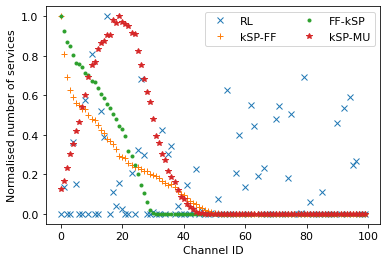

In [103]:
plt.plot(mean_channel_dist_125pc, 'x', label='RL')
plt.plot(mean_channel_dist_kspff_125pc, '+', label='kSP-FF')
plt.plot(mean_channel_dist_ffksp_125pc, '.', label='FF-kSP')
plt.plot(mean_channel_dist_kspmu_125pc, '*', label='kSP-MU')
plt.legend(ncol=2)
plt.xlabel("Channel ID")
plt.ylabel("Normalised number of services")
# plt.savefig('figures/channel_distribution_comp_125pc', dpi=500,bbox_inches='tight')
plt.show() 

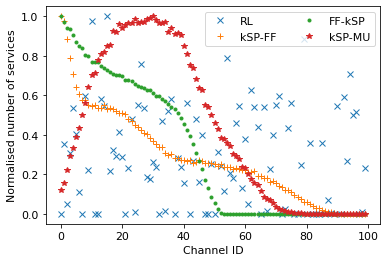

In [104]:
plt.plot(mean_channel_dist_25pc, 'x', label='RL')
plt.plot(mean_channel_dist_kspff_25pc, '+', label='kSP-FF')
plt.plot(mean_channel_dist_ffksp_25pc, '.', label='FF-kSP')
plt.plot(mean_channel_dist_kspmu_25pc, '*', label='kSP-MU')
plt.legend(ncol=2)
plt.xlabel("Channel ID")
plt.ylabel("Normalised number of services")
plt.savefig('figures/channel_distribution_comp_25pc', dpi=500,bbox_inches='tight')
plt.show() 

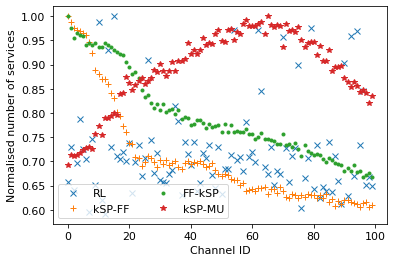

In [105]:
plt.plot(mean_channel_dist, 'x', label='RL')
plt.plot(mean_channel_dist_kspff, '+', label='kSP-FF')
plt.plot(mean_channel_dist_ffksp, '.', label='FF-kSP')
plt.plot(mean_channel_dist_kspmu, '*', label='kSP-MU')
plt.legend(ncol=2)
plt.xlabel("Channel ID")
plt.ylabel("Normalised number of services")
plt.savefig('figures/channel_distribution_comp', dpi=500,bbox_inches='tight')
plt.show() 

In [38]:
print(np.std(mean_channel_dist))
print(np.std(mean_channel_dist_kspff))
print(np.std(mean_channel_dist_kspmu))
print(np.std(mean_channel_dist_ffksp))

0.09737882052991405
0.10510227709456843
0.07973139361544469
0.08925654663635565


**Look at distribution across links**

In [108]:
mean_link_dist_125pc = np.mean(serdist_rl_mean_125pc, axis=1) / np.max(np.mean(serdist_rl_mean_125pc, axis=1))
mean_link_dist_25pc = np.mean(serdist_rl_mean_25pc, axis=1) / np.max(np.mean(serdist_rl_mean_25pc, axis=1))
mean_link_dist = np.mean(serdist_rl_mean, axis=1) / np.max(np.mean(serdist_rl_mean, axis=1))

In [111]:
mean_link_dist_ffksp_125pc = np.mean(serdist_ffksp_mean_125pc, axis=1) / np.max(np.mean(serdist_ffksp_mean_125pc, axis=1))
mean_link_dist_kspff_125pc = np.mean(serdist_kspff_mean_125pc, axis=1) / np.max(np.mean(serdist_kspff_mean_125pc, axis=1))
mean_link_dist_kspmu_125pc = np.mean(serdist_kspmu_mean_125pc, axis=1) / np.max(np.mean(serdist_kspmu_mean_125pc, axis=1))
mean_link_dist_ffksp_25pc = np.mean(serdist_ffksp_mean_25pc, axis=1) / np.max(np.mean(serdist_ffksp_mean_25pc, axis=1))
mean_link_dist_kspff_25pc = np.mean(serdist_kspff_mean_25pc, axis=1) / np.max(np.mean(serdist_kspff_mean_25pc, axis=1))
mean_link_dist_kspmu_25pc = np.mean(serdist_kspmu_mean_25pc, axis=1) / np.max(np.mean(serdist_kspmu_mean_25pc, axis=1))
mean_link_dist_ffksp = np.mean(serdist_ffksp_mean, axis=1) / np.max(np.mean(serdist_ffksp_mean, axis=1))
mean_link_dist_kspff = np.mean(serdist_kspff_mean, axis=1) / np.max(np.mean(serdist_kspff_mean, axis=1))
mean_link_dist_kspmu = np.mean(serdist_kspmu_mean, axis=1) / np.max(np.mean(serdist_kspmu_mean, axis=1))

MAE of link distribution for RL vs heuristics - very different to FF-kSP at the start, similar at the end...

In [139]:
print(np.mean(abs(mean_link_dist_25pc - mean_link_dist_ffksp_25pc)))
print(np.mean(abs(mean_link_dist - mean_link_dist_ffksp)))
print(np.mean(abs(mean_link_dist_25pc - mean_link_dist_kspff_25pc)))
print(np.mean(abs(mean_link_dist - mean_link_dist_kspff)))
print(np.mean(abs(mean_link_dist_25pc - mean_link_dist_kspmu_25pc)))
print(np.mean(abs(mean_link_dist - mean_link_dist_kspmu)))

0.25132878279074294
0.04602490560843608
0.08043849285032943
0.0374748391058462
0.08044573030328896
0.04571236604631053


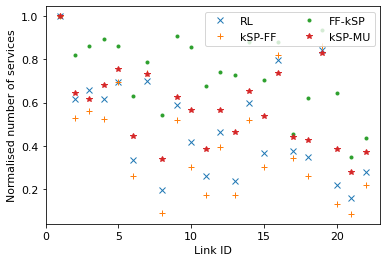

In [131]:
link_ids = np.arange(1,23,1)
plt.plot(link_ids, mean_link_dist_125pc, 'x', label='RL')
plt.plot(link_ids, mean_link_dist_kspff_125pc, '+', label='kSP-FF')
plt.plot(link_ids, mean_link_dist_ffksp_125pc, '.', label='FF-kSP')
plt.plot(link_ids, mean_link_dist_kspmu_125pc, '*', label='kSP-MU')
plt.legend(ncol=2)
plt.xlabel("Link ID")
plt.ylabel("Normalised number of services")
plt.xlim([0,23])
# plt.savefig('figures/link_distribution_comp_125pc', dpi=500,bbox_inches='tight')
plt.show() 

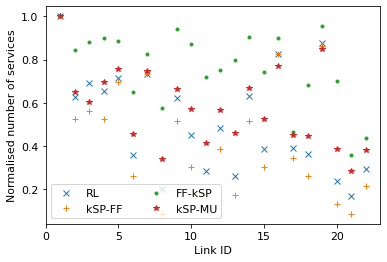

In [129]:
link_ids = np.arange(1,23,1)
plt.plot(link_ids, mean_link_dist_25pc, 'x', label='RL')
plt.plot(link_ids, mean_link_dist_kspff_25pc, '+', label='kSP-FF')
plt.plot(link_ids, mean_link_dist_ffksp_25pc, '.', label='FF-kSP')
plt.plot(link_ids, mean_link_dist_kspmu_25pc, '*', label='kSP-MU')
plt.legend(ncol=2)
plt.xlabel("Link ID")
plt.ylabel("Normalised number of services")
plt.xlim([0,23])
plt.savefig('figures/link_distribution_comp_25pc', dpi=500,bbox_inches='tight')
plt.show() 

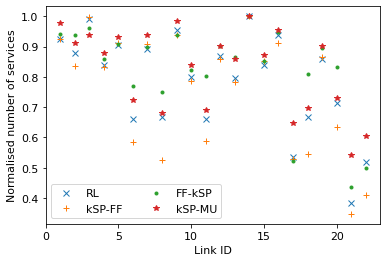

In [128]:
link_ids = np.arange(1,23,1)
plt.plot(link_ids, mean_link_dist, 'x', label='RL')
plt.plot(link_ids, mean_link_dist_kspff, '+', label='kSP-FF')
plt.plot(link_ids, mean_link_dist_ffksp, '.', label='FF-kSP')
plt.plot(link_ids, mean_link_dist_kspmu, '*', label='kSP-MU')
plt.legend(ncol=2)
plt.xlabel("Link ID")
plt.ylabel("Normalised number of services")
plt.xlim([0,23])
# plt.grid()
plt.savefig('figures/link_distribution_comp', dpi=500,bbox_inches='tight')
plt.show() 

In [ ]:
# serdist_rl_mean_25pc[0]/np.max(serdist_rl_mean_25pc[0])

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist_125pc),max(mean_channel_dist_125pc),100), '+')
plt.plot(mean_channel_dist_125pc, 'x')
plt.show() 

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist_25pc),max(mean_channel_dist_25pc),100), '+')
plt.plot(mean_channel_dist_25pc, 'x')
plt.show() 

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist_375pc),max(mean_channel_dist_375pc),100), '+')
plt.plot(mean_channel_dist_375pc, 'x')
plt.show() 

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist_50pc),max(mean_channel_dist_50pc),100), '+')
plt.plot(mean_channel_dist_50pc, 'x')
plt.show()

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist_625pc),max(mean_channel_dist_625pc),100), '+')
plt.plot(mean_channel_dist_625pc, 'x')
plt.show() 

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist_75pc),max(mean_channel_dist_75pc),100), '+')
plt.plot(mean_channel_dist_75pc, 'x')
plt.show()

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist_875pc),max(mean_channel_dist_875pc),100), '+')
plt.plot(mean_channel_dist_875pc, 'x')
plt.show() 

In [ ]:
plt.plot(np.random.uniform(min(mean_channel_dist),max(mean_channel_dist),100), '+')
plt.plot(mean_channel_dist, 'x')
plt.show()

In [ ]:
kl_div(mean_channel_dist, np.random.uniform(0,100,100))

Mapping of topology to edge indices and then to length ordered edge indices:  
S D Length Original length-ordered  
1 2 1000 -->   0  --> 14  
1 3 1500 -->   1  --> 17  
1 8 2400 -->   2  --> 21  
2 3 600  -->   3   --> 7  
2 4 700  -->   4   --> 12  
3 6 1800 -->   5   --> 19  
4 5 600  -->   6   --> 6  
4 11 1900-->   7   --> 20  
5 6 1200 -->   8   --> 15  
5 7 600  -->   9   --> 5  
6 10 1000-->   10  --> 13  
6 14 1800-->   11  --> 18  
7 8 700  -->   12  --> 11  
7 10 1300-->   13  --> 16  
8 9 700  -->   14  --> 10  
9 10 700 -->   15  --> 9  
9 12 300 -->   16  --> 3  
9 13 300 -->   17  --> 2  
11 12 600-->   18  --> 4  
11 13 700-->   19  --> 8  
12 14 300-->   20  --> 1  
13 14 100-->   21  --> 0  

In [ ]:
len_ordered_edge_inds = [21,20,17,16,18,9,6,3,19,15,14,12,4,10,0,8,13,1,11,5,7,2]
len(len_ordered_edge_inds)

Calculate average over multiple runs

In [ ]:
exp_id_r1 = "2022-03-07v7nsfU100G"
exp_id_r2 = "2022-03-07v7nsfU100GR2"
exp_id_r3 = "2022-03-07v7nsfU100GR3"
exp_id_r4 = "2022-03-07v7nsfU100GR4"
exp_id_r5 = "2022-03-07v7nsfU100GR5"

R1_mean = pickle.load(open("results/"+exp_id_r1+"_mean.pkl",'rb'))
R2_mean = pickle.load(open("results/"+exp_id_r2+"_mean.pkl",'rb'))
R3_mean = pickle.load(open("results/"+exp_id_r3+"_mean.pkl",'rb'))
R4_mean = pickle.load(open("results/"+exp_id_r4+"_mean.pkl",'rb'))
# R5_mean = pickle.load(open("results/"+exp_id_r5+"_mean.pkl",'rb'))
ave_mean = np.mean([R1_mean,R2_mean,R3_mean,R4_mean])
R1_median = pickle.load(open("results/"+exp_id_r1+"_median.pkl",'rb'))
R2_median = pickle.load(open("results/"+exp_id_r2+"_median.pkl",'rb'))
R3_median = pickle.load(open("results/"+exp_id_r3+"_median.pkl",'rb'))
R4_median = pickle.load(open("results/"+exp_id_r4+"_median.pkl",'rb'))
# R5_median = pickle.load(open("results/"+exp_id_r5+"_median.pkl",'rb'))
ave_median = np.mean([R1_median,R2_median,R3_median,R4_median])
R1_std = pickle.load(open("results/"+exp_id_r1+"_std.pkl",'rb'))
R2_std = pickle.load(open("results/"+exp_id_r2+"_std.pkl",'rb'))
R3_std = pickle.load(open("results/"+exp_id_r3+"_std.pkl",'rb'))
R4_std = pickle.load(open("results/"+exp_id_r4+"_std.pkl",'rb'))
# R5_std = pickle.load(open("results/"+exp_id_r5+"_std.pkl",'rb'))
ave_std = np.mean([R1_std,R2_std,R3_std,R4_std])

In [ ]:
print("Mean:",ave_mean)
print("Median:",ave_median)
print("Std:",ave_std)

Plotting for multiple RL agents:

In [ ]:
current_directory = os.getcwd()

exp_id_m_u = "2022-03-10v45nsfU100GR2"  
exp_id_nm_u = "2022-03-15v45nsfU100GnomaskR3"

exp_id_m_nu = "2022-03-15v45nsfUp5100GR3"
exp_id_nm_nu = "2022-03-16v45nsfUp50100GnomaskR5"  

eval_name = "_no_tfb"
route_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"
eval_dir_m_u = route_dir+exp_id_m_u+"/_core_0/eval_results"+eval_name
eval_dir_nm_u = route_dir+exp_id_nm_u+"/_core_0/eval_results"+eval_name
eval_dir_m_nu = route_dir+exp_id_m_nu+"/_core_0/eval_results"+eval_name
eval_dir_nm_nu = route_dir+exp_id_nm_nu+"/_core_0/eval_results"+eval_name

In [ ]:
rewards_rl_m_u, eval_eps_rl_m_u, sim_time_rl_m_u, services_accepted_ep_rl_m_u, services_processed_ep_rl_m_u, services_accepted_rl_m_u, services_processed_rl_m_u, throughput_rl_m_u = get_info(eval_dir_m_u, 'rl', False)
rewards_rl_nm_u, eval_eps_rl_nm_u, sim_time_rl_nm_u, services_accepted_ep_rl_nm_u, services_processed_ep_rl_nm_u, services_accepted_rl_nm_u, services_processed_rl_nm_u, throughput_rl_nm_u = get_info(eval_dir_nm_u, 'rl', False)
rewards_rl_m_nu, eval_eps_rl_m_nu, sim_time_rl_m_nu, services_accepted_ep_rl_m_nu, services_processed_ep_rl_m_nu, services_accepted_rl_m_nu, services_processed_rl_m_nu, throughput_rl_m_nu = get_info(eval_dir_m_nu, 'rl', False)
rewards_rl_nm_nu, eval_eps_rl_nm_nu, sim_time_rl_nm_nu, services_accepted_ep_rl_nm_nu, services_processed_ep_rl_nm_nu, services_accepted_rl_nm_nu, services_processed_rl_nm_nu, throughput_rl_nm_nu = get_info(eval_dir_nm_nu, 'rl', False)

In [ ]:
f, ax_1 = plt.subplots()
dict_plt_m = {'IAM RL':services_accepted_ep_rl_m_u}
dict_plt_nm = {'Standard RL':services_accepted_ep_rl_nm_u}
plt.boxplot(dict_plt_m.values(),showfliers=False,showmeans=True)


ax_2 = ax_1.twinx() 
plt.boxplot(dict_plt_nm.values(),showfliers=False,showmeans=True)

# ax_1.set_xticklabels(dict_plt_m.keys())
# ax_2.set_xticklabels(dict_plt_nm.keys())

plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
# plt.savefig('figures/masked_vs_unmasked_nonuniform_boxplot.png', dpi=500,bbox_inches='tight')
# plt.savefig('figures/masked_vs_unmasked_uniform_boxplot.png', dpi=500,bbox_inches='tight')
# plt.savefig('figures/masked_vs_unmasked_both_traffic_boxplot.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
f, ax = plt.subplots()
dict_plt = {'IAM RL U':services_accepted_ep_rl_m_u,'Stan. RL U':services_accepted_ep_rl_nm_u,
                'IAM RL non-U':services_accepted_ep_rl_m_nu,'Stan. RL non-U':services_accepted_ep_rl_nm_nu}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
# plt.savefig('figures/masked_vs_unmasked_nonuniform_boxplot.png', dpi=500,bbox_inches='tight')
# plt.savefig('figures/masked_vs_unmasked_uniform_boxplot.png', dpi=500,bbox_inches='tight')
plt.savefig('figures/masked_vs_unmasked_both_traffic_boxplot.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
topology = 'nsfnet'
f, ax = plt.subplots()
bp = dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp,
            'RL':services_accepted_ep_rl_1}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.legend([bp["boxes"][0]], ['A'], loc='upper right')
plt.grid()
#plt.savefig('figures/servicesaccepted_bestresults'+topology+eval_name_plot+'modelA.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
medians = [item.get_ydata()[0] for item in bp['medians']]
means = [item.get_ydata()[0] for item in bp['means']]
print(f'Medians: {medians}\n'
      f'Means:   {means}')

In [ ]:
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
print(f'Minimums: {minimums}\n'
      f'Maximums: {maximums}')
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
# print(f'Q1: {q1}\n'
#       f'Q3: {q3}')
IQR = [q3[i] - q1[i] for i in range(len(q1))]
print(IQR)

Timing results

In [ ]:
rl_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_RL.pkl", 'rb'))
kspff_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_kspff.pkl", 'rb'))
ffksp_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_ffksp.pkl", 'rb'))
camu_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_camu.pkl", 'rb'))
kspmu_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_kspmu.pkl", 'rb'))

In [ ]:
print(rl_time)
print(kspff_time)
print(ffksp_time)
print(camu_time)
print(kspmu_time)